# Evaluation of probabilistic Forecasts

Ths notebooks gives a brief overview on qualitaive evaluation methods for probabilistic forecasts, as described in:

> S. Haben, M. Voss, und W. Holderbaum, Core Concepts and Methods in Load Forecasting: With Applications in Distribution Networks. Cham: Springer International Publishing, 2023. doi: 10.1007/978-3-031-27852-5.

## Imports

In [16]:
import numpy as np

import tensorflow as tf
import tensorflow_probability as tfp

from tensorflow_probability import distributions as tfd

from matplotlib import pyplot as plt

## Seed

In [66]:
seed=1
np.random.seed(seed)
tf.random.set_seed(seed)

## Function Definitions

In [18]:
def ecdf(samples, x):
    ss = np.sort(samples)  # [..., None]
    cdf = np.searchsorted(ss, x, side="right") / float(ss.size)
    return cdf

In [33]:
def gen_pit_hist(ax, samples, measurements, **kwds):
    ecdf_samples = ecdf(samples, measurements.squeeze())

    pit_hist(ax, ecdf_samples, **kwds)

In [32]:
def pit_hist(ax, ecdf_samples, bins=20, title="Probability Integral Transform (PIT) Histograms", **kwds):
    ax.hist(ecdf_samples.T, bins=bins, **kwds)

    ax.set_title(title)
    ax.set_xlabel("PIT=$F(y)$")
    ax.set_ylabel("Freqency")

In [56]:
def gen_reliablity_diagram(ax, samples, measurements, **kwds):
    measurements = np.sort(measurements)
    ecdf_estimated = ecdf(samples, measurements.squeeze())
    ecdf_measurements = ecdf(measurements, measurements.squeeze())

    reliablity_diagram(ax, ecdf_estimated, ecdf_measurements, **kwds)

In [57]:
def reliablity_diagram(ax, ecdf_estimated, ecdf_measurements, title="Reliability Diagram", **kwds):
    ax.plot([0, 1], [0, 1], "k:")

    ax.plot(ecdf_estimated, ecdf_measurements, **kwds)

    ax.set_title(title)
    ax.set_xlabel("Estimated Quantile")
    ax.set_ylabel("Observed Quantile")

    return ax

# Reliability

reliability is the property of a probabilistic forecast to predict probabilities that fit to the relative frequencies in the data.

## Toy Data

In [58]:
# Lets generate three Nomrmal Distributions with different scale
true_norm = tfd.Normal(0,1, name='true')
overdispersed = tfd.Normal(0,1.5, name='overdispersed')
underdispersed = tfd.Normal(0,0.5, name='underdispersed')

In [67]:
measurements = true_norm.sample(10000).numpy()
measurements = np.sort(measurements)

true_samples = true_norm.sample(len(measurements)).numpy()
overdispersed_samples = overdispersed.sample(len(measurements)).numpy()
underdispersed_samples = underdispersed.sample(len(measurements)).numpy()

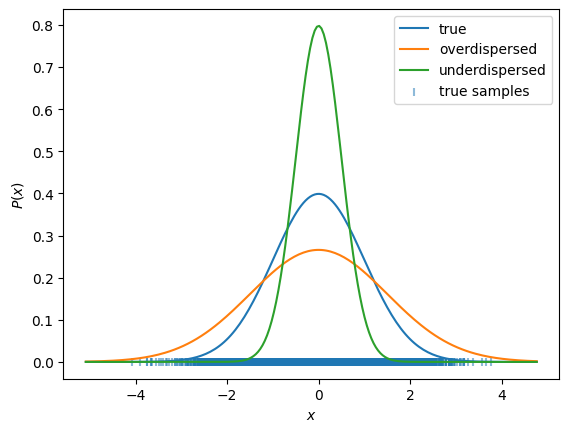

In [60]:
y=np.linspace(min(measurements) - 1, max(measurements) + 1, 200, dtype=np.float32)
plt.plot(y, true_norm.prob(y), label='true')
plt.plot(y, overdispersed.prob(y), label='overdispersed')
plt.plot(y, underdispersed.prob(y), label='underdispersed')
plt.scatter(measurements, np.zeros_like(true_samples), marker='|', alpha=0.5, label='true samples')

plt.xlabel('$x$')
plt.ylabel('$P(x)$')
plt.legend()

## Empirical step function

$\hat{F}_E(y)=\frac{\text{number observations}\leq X}{N}$

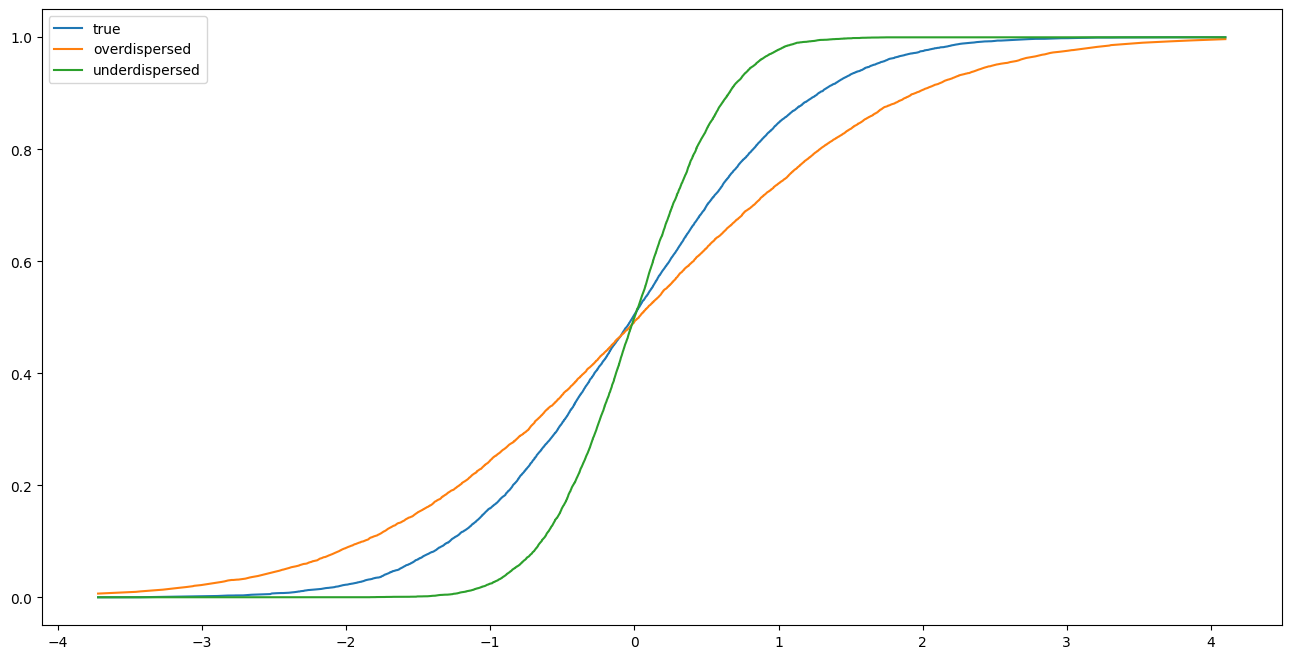

In [72]:
plt.figure(figsize=(16,8))

plt.plot(measurements, ecdf(true_samples, measurements), label="true")
plt.plot(measurements, ecdf(overdispersed_samples, measurements), label="overdispersed")
plt.plot(measurements, ecdf(underdispersed_samples, measurements), label="underdispersed")
plt.legend()

## Probability Integral Transform (PIT)

- probability integral transform (PIT) histograms
  - the continuous counterpart of verification rank histograms and show the distribution the probability integral transform, which is

    $\text{PIT}_t=\hat{F}_t(y_t)$

    where $\hat{F}_t(y_t)$ is the predicted cumulative distribution function.
  - If the forecasts are well calibrated and reliable, the PIT histogram should be flat as well
- *Note:* when discrete cumulative distribution functions are derived from ensemble forecasts, the resulting PIT histogram is almost identical to the verification rank histogram only with a different scale on the x-axis
- *Reliability is a crucial property of probabilistic forecasts.*
  Unreliable forecasts can lead to not ideal decisions and thus to financial loss.
- PIT histograms should therefore be one of the first steps in evaluating probabilistic forecasts, and if they deviate significantly from uniformity, the forecasts should be calibrated or only used with care
- Reliability should also be seen more like a property a forecast has or does not have, and the reliability of different forecasts should in general not be ranked.
- *A uniform PIT is only a necessary condition and not sufficent for the distribution to be true!*


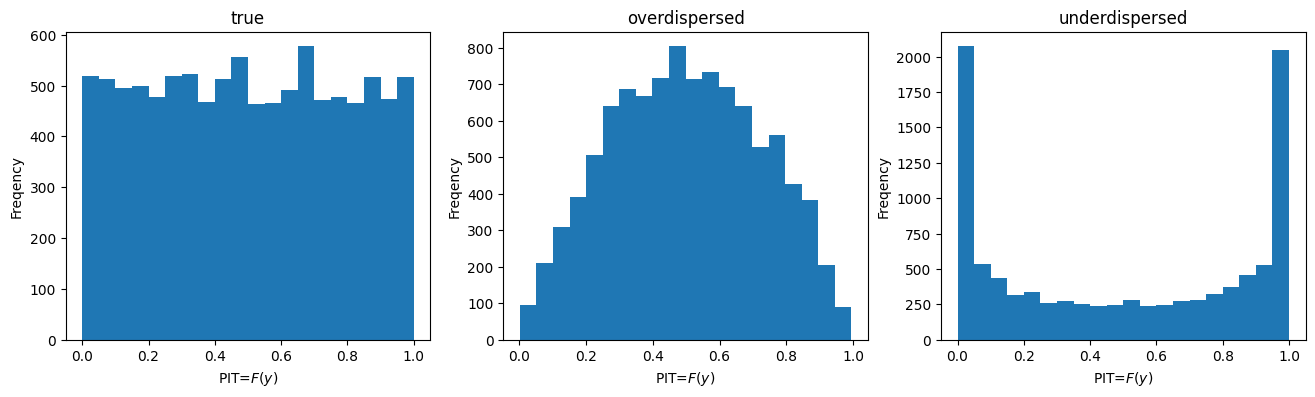

In [61]:
fig, ax = plt.subplots(1, 3, figsize=(16,4))

gen_pit_hist(ax[0], true_samples, measurements, title="true")
gen_pit_hist(ax[1], overdispersed_samples, measurements, title="overdispersed")
gen_pit_hist(ax[2], underdispersed_samples, measurements, title="underdispersed")

# Reliability Diagram

- *A probabilistic forecast that is not reliable can lead to wrong decisions when the predicted probabilities are interpreted directly*.
- Sould be seen as a *necessary condition of a good probabilistic forecast*, similar to the bias for deterministic forecasts
- The observed frequencies are plotted against the predicted probabilities.
  Therefore, the interval (0, 1) is divided into several subintervals, and relative frequencies conditional on forecasts falling in each of these intervals are plotted against the interval centre or median.
- The quantiles of the probabilistic forecast are plottet against the observed frequencies.
- For reliable forecasts, observed and predicted frequencies should be similar so that their reliability diagram should be close to a diagonal line
- Traditionally, reliability diagrams also contain a refinement distribution subplot which show histograms of the predicted probabilities, eg, cite:Wilks2011.
- consistency bars as in cite:Brocker2007a


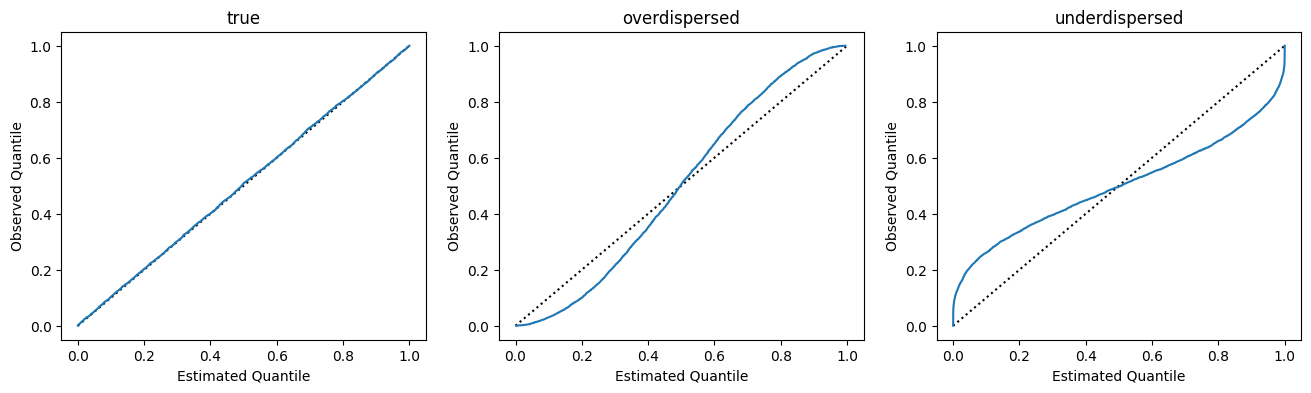

In [62]:
fig, ax = plt.subplots(1, 3, figsize=(16,4))

gen_reliablity_diagram(ax[0], true_samples, measurements, title="true")
gen_reliablity_diagram(ax[1], overdispersed_samples, measurements, title="overdispersed")
gen_reliablity_diagram(ax[2], underdispersed_samples, measurements, title="underdispersed")